In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import PIL
import random
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [2]:
transform = transforms.Compose(
    [transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5],
                        [0.5, 0.5, 0.5])]
)

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
#dowload the datasets
import zipfile
!kaggle datasets download -d shaunthesheep/microsoft-catsvsdogs-dataset
zipfile.ZipFile('microsoft-catsvsdogs-dataset.zip').extractall('./data')

Dataset URL: https://www.kaggle.com/datasets/shaunthesheep/microsoft-catsvsdogs-dataset
License(s): other
 99% 780M/788M [00:11<00:00, 92.0MB/s]
100% 788M/788M [00:11<00:00, 69.1MB/s]


In [5]:
data_dir = "/content/data/PetImages"

In [6]:
# Add imports for os and PIL (although PIL is likely already implicitly imported by torchvision)
import os
from PIL import Image, UnidentifiedImageError

# Add code to filter out corrupted images
print("Checking for corrupted images...")
removed_count = 0
for category in ['Cat', 'Dog']:
    category_path = os.path.join(data_dir, category)
    for img_name in os.listdir(category_path):
        img_path = os.path.join(category_path, img_name)
        try:
            # Attempt to open the image with PIL.
            # Setting verify_existence=False for speed,
            # the UnidentifiedImageError is caught below.
            # The .load() method is crucial to actually read the image data
            # and catch errors early.
            img = Image.open(img_path)
            img.load() # This forces the loading of image data
        except (UnidentifiedImageError, OSError) as e:
            print(f"Removing corrupted image: {img_path} - {e}")
            try:
                os.remove(img_path)
                removed_count += 1
            except OSError as e:
                print(f"Error removing file {img_path}: {e}")

print(f"Finished checking. Removed {removed_count} corrupted images.")

Checking for corrupted images...
Removing corrupted image: /content/data/PetImages/Cat/666.jpg - cannot identify image file '/content/data/PetImages/Cat/666.jpg'
Removing corrupted image: /content/data/PetImages/Cat/Thumbs.db - cannot identify image file '/content/data/PetImages/Cat/Thumbs.db'


/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Removing corrupted image: /content/data/PetImages/Dog/11702.jpg - cannot identify image file '/content/data/PetImages/Dog/11702.jpg'
Removing corrupted image: /content/data/PetImages/Dog/Thumbs.db - cannot identify image file '/content/data/PetImages/Dog/Thumbs.db'
Finished checking. Removed 4 corrupted images.


In [7]:
full_dataset = datasets.ImageFolder(root=data_dir, transform=transform)

In [8]:
train_size = int(0.8 * len(full_dataset)) # 80% for training
test_size = int(len(full_dataset)) - train_size # 20% for testing

print(train_size, test_size)

train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

19998 5000


In [9]:
train_dataset[0][0].size()

torch.Size([3, 256, 256])

In [10]:
train_dataset.dataset.transform = transform
test_dataset.dataset.transform = transform

In [11]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [12]:
class_names = full_dataset.classes
class_names

['Cat', 'Dog']

In [13]:
class CatDogClassifier(nn.Module):
    def __init__(self):
        super(CatDogClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.conv3 = nn.Conv2d(64, 128, 3, 1)
        self.conv4 = nn.Conv2d(128, 256, 3, 1)
        self.dropL = nn.Dropout(0.5)

        # Create dummy input to determine fc1 input size dynamically
        self._to_linear = None
        self._get_flatten_size()

        self.fc1 = nn.Linear(self._to_linear, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 2)

    def _get_flatten_size(self):
        # This method will run a dummy forward pass to calculate the output size
        with torch.no_grad():
            x = torch.randn(1, 3, 256, 256)
            x = self.pool(F.relu(self.conv1(x)))
            x = self.pool(F.relu(self.conv2(x)))
            x = self.pool(F.relu(self.conv3(x)))
            x = self.pool(F.relu(self.conv4(x)))
            self._to_linear = x.view(1, -1).size(1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.dropL(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [14]:
model = CatDogClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [15]:
epochs = 5
train_loss = []
train_accuracy = []
correct = 0
total = 0

for epoch in range(epochs):
    running_loss = 0.0
    model.train()
    for i, data in enumerate(train_loader, 1):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    accuracy = 100 * correct / total
    train_loss.append(running_loss / len(train_loader))
    train_accuracy.append(accuracy)

    print(f"Epoch {epoch+1}, train_loss: {running_loss / len(train_loader):.3f}, train_accuracy: {accuracy:.2f}%")

Epoch 1, train_loss: 0.628, train_accuracy: 62.29%
Epoch 2, train_loss: 0.491, train_accuracy: 69.22%
Epoch 3, train_loss: 0.417, train_accuracy: 73.02%
Epoch 4, train_loss: 0.353, train_accuracy: 75.86%
Epoch 5, train_loss: 0.310, train_accuracy: 78.05%


In [16]:
test_accuracy = []
epochs = 10
correct = 0
total = 0

for epoch in range(epochs):
    with torch.no_grad():
        for data in test_loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = (100 * correct) / total
    test_accuracy.append(accuracy)
    print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader):.3f}, Test Accuracy: {accuracy:.2f}%")

Epoch 1, Loss: 0.310, Test Accuracy: 87.46%
Epoch 2, Loss: 0.310, Test Accuracy: 87.57%
Epoch 3, Loss: 0.310, Test Accuracy: 87.44%
Epoch 4, Loss: 0.310, Test Accuracy: 87.51%
Epoch 5, Loss: 0.310, Test Accuracy: 87.50%
Epoch 6, Loss: 0.310, Test Accuracy: 87.49%
Epoch 7, Loss: 0.310, Test Accuracy: 87.41%
Epoch 8, Loss: 0.310, Test Accuracy: 87.44%
Epoch 9, Loss: 0.310, Test Accuracy: 87.43%
Epoch 10, Loss: 0.310, Test Accuracy: 87.46%


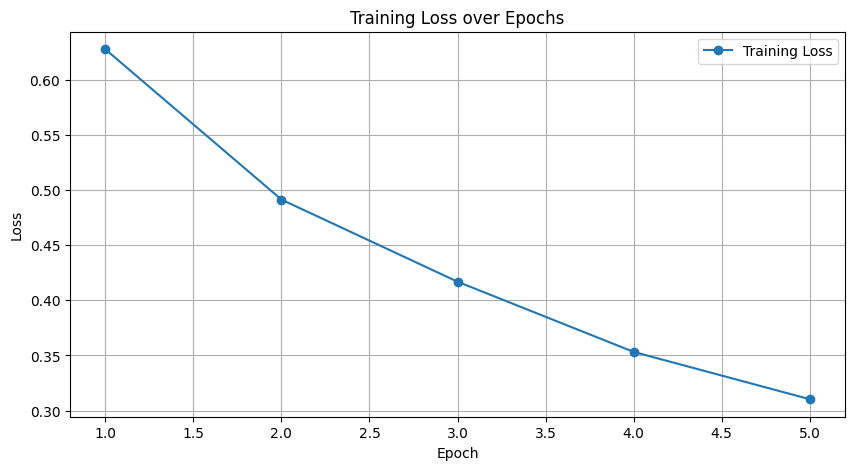

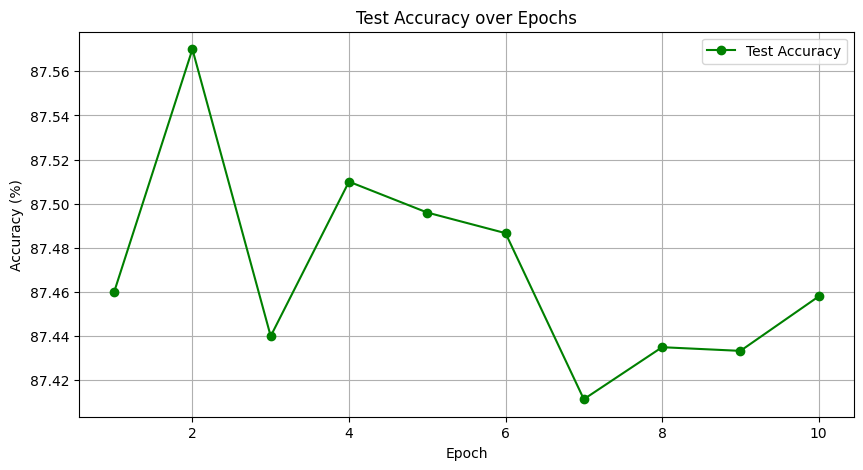

In [17]:
# Plot training loss
plt.figure(figsize=(10,5))
# Use the actual number of training epochs for the x-axis
plt.plot(range(1, len(train_loss) + 1), train_loss, marker='o', label='Training Loss')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Use the number of epochs from the testing loop for plotting test accuracy
# The 'epochs' variable is already set to 10 in the previous cell
# so it will be 10 here.

# Plot test accuracy
plt.figure(figsize=(10,5))
plt.plot(range(1, epochs+1), test_accuracy, marker='o', color='green', label='Test Accuracy')
plt.title('Test Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()

In [18]:
print(f'Final Test Accuracy: {test_accuracy[-1]:.2f}%')

Final Test Accuracy: 87.46%


In [19]:
# Save the trained model
torch.save(model.state_dict(), 'cat_dog_model.pth')

In [20]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

def predict_image_class(image_path, model, class_names, device, transform):
    """
    Predicts the class of an image and displays the image with the prediction.

    Args:
        image_path (str): Path to the input image.
        model (torch.nn.Module): Trained PyTorch model.
        class_names (list): List of class names (e.g., ['Cat', 'Dog']).
        device (torch.device): Device to run the model on (e.g., 'cuda' or 'cpu').
        transform (torchvision.transforms.Compose): Image transformations to apply.
    """
    try:
        # Load the image
        image = Image.open(image_path).convert('RGB') # Ensure image is in RGB

        # Apply transformations
        image_transformed = transform(image).unsqueeze(0).to(device)

        # Set model to evaluation mode
        model.eval()

        # Make prediction
        with torch.no_grad():
            outputs = model(image_transformed)
            _, predicted_idx = torch.max(outputs, 1)
            predicted_class = class_names[predicted_idx.item()]

        # Display the image and prediction
        plt.imshow(image)
        plt.title(f"Predicted: {predicted_class}")
        plt.axis('off')
        plt.show()

    except FileNotFoundError:
        print(f"Error: Image file not found at {image_path}")
    except Exception as e:
        print(f"An error occurred: {e}")

# Example usage:
# Assuming you have an image file named 'test_image.jpg'
# in the same directory or provide the full path.

# Replace 'path/to/your/test_image.jpg' with the actual path to your image file
# predict_image_class('path/to/your/test_image.jpg', model, class_names, device, transform)

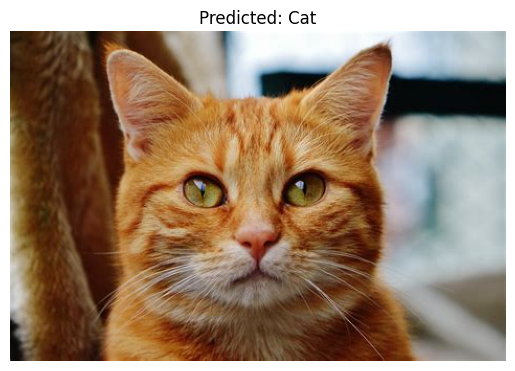

In [26]:
img_path = "/content/catimage.jpg"
transform_img = transforms.Compose(
    [transforms.Resize((256, 256)),
     transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5],
                        [0.5, 0.5, 0.5])]
)

predict_image_class(img_path, model, class_names, device, transform_img)

In [27]:
torch.save(model.state_dict(), 'cat_dog_model.pth')